In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from numpy.random import normal, poisson, beta
from scipy.linalg import sqrtm
from graspologic.embed import AdjacencySpectralEmbed
from graspologic.models import DCSBMEstimator, EREstimator, SBMEstimator
from graspologic.models.sbm import _block_to_full, _get_block_indices
from graspologic.simulations import er_np, sbm, rdpg
from graspologic.plot import heatmap
%matplotlib inline

In [ ]:
np.random.seed(123)

n = [100, 100]
B = np.array([[0.1, 0.05],
     [0.05, 0.15]])
wt = [[beta, beta],
      [beta, beta]]
wtargs = [[dict(a=2, b=1), dict(a=2, b=1)],
          [dict(a=2, b=1), dict(a=2, b=1)]]



G = sbm(n=n, p=B, wt=wt, wtargs=wtargs)

np.random.seed(123)

wt = [[np.random.beta(a=2, b=1), np.random.beta(a=2, b=1)],[np.random.beta(a=2, b=1), np.random.beta(a=2, b=1)]]

z1 = [[1, 0]]* n[0]
z2 = [[0, 1]]* n[1]
z = np.array(z1+z2)

B_dcsbm = B.copy()

for i in range(len(B)):
      for j in range(len(B[i])):
            B_dcsbm[i][j] = B[i][j]* wt[i][j]

B_sqrt = sqrtm(B_dcsbm)

X = z @ B_sqrt

np.random.seed(123)

G1 = rdpg(X)

In [ ]:
_ = heatmap(G, title='Weighted SBM Simulation')
_ = heatmap(G1 , title='Weighted SBM Simulation(Z @ sqrtm(B))')


Now replicate figure 1

In [226]:
n = 1000


B = np.array([[0.1, 0.05],
              [0.05, 0.15]])

community_sizes = [n // 2, n // 2]

labels_c1 = [0] * community_sizes[0]
labels_c2 = [1] * community_sizes[1]
labels_scatter = np.array(labels_c1 + labels_c2)

degree_corrections = np.random.beta(2, 1, size=n)
'''for label in np.unique(labels):
    mask = labels == label
    degree_corrections[mask] = np.sort(degree_corrections[mask])[::-1]
    comm_sum = np.sum(degree_corrections[mask])
    degree_corrections[mask] = degree_corrections[mask] / comm_sum'''

dcsbm_graph = sbm(community_sizes, B, dc=degree_corrections, loops=False)

ase = AdjacencySpectralEmbed(n_components=2, check_lcc=False)

graph_latent = ase.fit_transform(dcsbm_graph)

In [227]:
def simple_scatter(X, ax, y=None):
    sns.scatterplot(
        x=X[:, 0],
        y=X[:, 1],
        hue=y,
        s=15,
        linewidth=0.25,
        alpha=0.5,
        ax=ax,
        legend=False,
    )
    ax.set(xticks=[-0.15, 0.5, 1], yticks=[-1, 0, 1], xlabel=r"$\mathbf{X}_1$", ylabel=r"$\mathbf{X}_2$", xlim=(-0.15, 1), ylim=(-1, 1), title=r"$\hat\mathbf{X}$")

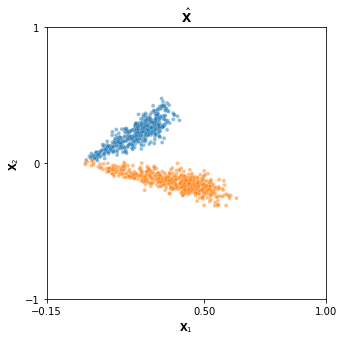

In [228]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
simple_scatter(graph_latent, ax, y=labels_scatter)

In [229]:
graph_latent @ graph_latent.T

array([[0.02801858, 0.05824556, 0.02893099, ..., 0.02049588, 0.01594991,
        0.00590485],
       [0.05824556, 0.12258512, 0.05983311, ..., 0.03116336, 0.02785429,
        0.01167215],
       [0.02893099, 0.05983311, 0.02993669, ..., 0.02351701, 0.01755993,
        0.00622115],
       ...,
       [0.02049588, 0.03116336, 0.02351701, ..., 0.10211708, 0.05203782,
        0.0089099 ],
       [0.01594991, 0.02785429, 0.01755993, ..., 0.05203782, 0.02778588,
        0.00548846],
       [0.00590485, 0.01167215, 0.00622115, ..., 0.0089099 , 0.00548846,
        0.0014863 ]])

In [230]:
degree_corrections = np.random.beta(2, 1, size=n)

z1 = [[1, 0]]* community_sizes[0]
z2 = [[0, 1]]* community_sizes[1]
z = np.array(z1+z2)

Z1 = np.multiply(z[:, 0], degree_corrections)
Z2 = np.multiply(z[:, 1], degree_corrections)
Z = np.vstack((Z1,Z2)).T

P = Z @ B @ Z.T
P

array([[0.03744403, 0.05186302, 0.05174401, ..., 0.02059683, 0.0216233 ,
        0.02886828],
       [0.05186302, 0.07183448, 0.07166965, ..., 0.02852828, 0.02995002,
        0.0399849 ],
       [0.05174401, 0.07166965, 0.07150519, ..., 0.02846282, 0.02988129,
        0.03989315],
       ...,
       [0.02059683, 0.02852828, 0.02846282, ..., 0.06797816, 0.07136593,
        0.0952774 ],
       [0.0216233 , 0.02995002, 0.02988129, ..., 0.07136593, 0.07492254,
        0.10002566],
       [0.02886828, 0.0399849 , 0.03989315, ..., 0.0952774 , 0.10002566,
        0.1335397 ]])

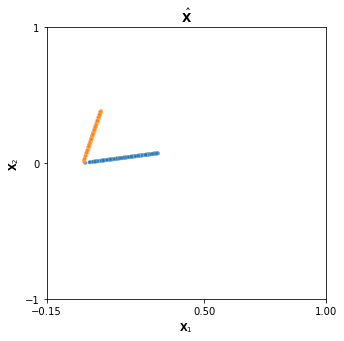

In [231]:
B_sqrt = sqrtm(B)

X = Z @ B_sqrt

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
simple_scatter(X, ax, y=labels_scatter)

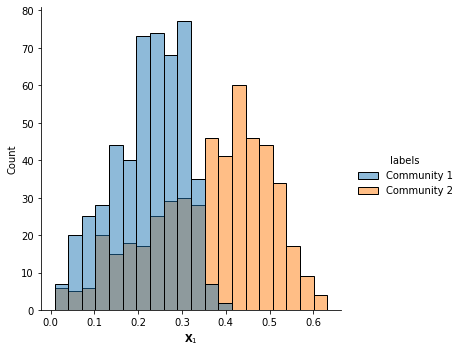

In [243]:
import pandas as pd

labels_1 = ["Community 1"]*community_sizes[0]
labels_2 = ["Community 2"]*community_sizes[1]
labels = np.array(labels_1 + labels_2)

x1_hist = {r"$\mathbf{X}_1$": graph_latent[:, 0], 'labels': labels}
x1_hist = pd.DataFrame(data=x1_hist)

sns.displot(data=x1_hist, x=r"$\mathbf{X}_1$", hue="labels", bins = 20)

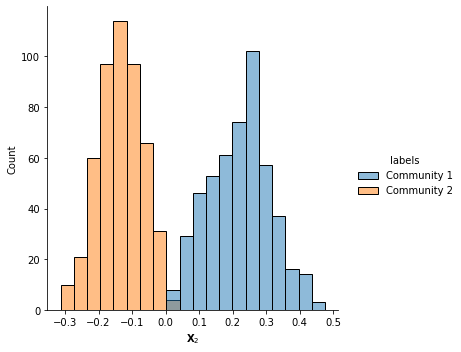

In [240]:
x2_hist = {r"$\mathbf{X}_2$": graph_latent[:, 1], 'labels': labels}
x2_hist = pd.DataFrame(data=x2_hist)

sns.displot(data=x2_hist, x=r"$\mathbf{X}_2$", hue="labels", bins = 20)

Now check with normalized latent positions

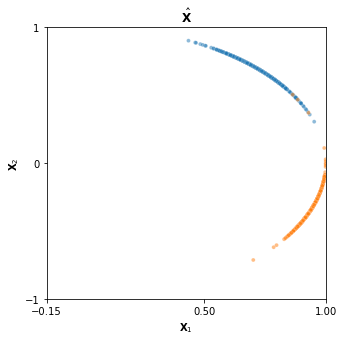

In [235]:
from sklearn.preprocessing import normalize

X_norm = normalize(graph_latent)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
simple_scatter(X_norm, ax, y=labels_scatter)

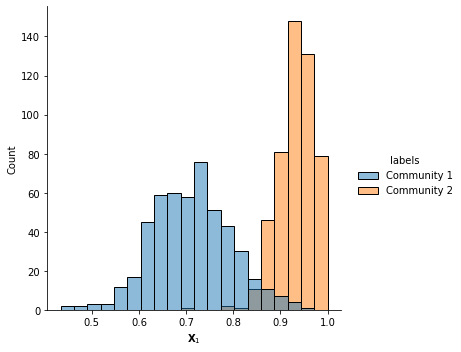

In [241]:
x1norm_hist = {r"$\mathbf{X}_1$": X_norm[:, 0], 'labels': labels}
x1norm_hist = pd.DataFrame(data=x1norm_hist)

sns.displot(data=x1norm_hist, x=r"$\mathbf{X}_1$", hue="labels", bins = 20)

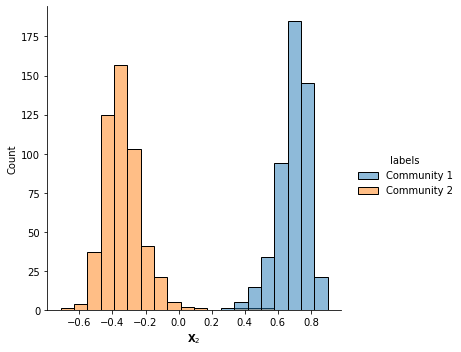

In [242]:
x2norm_hist = {r"$\mathbf{X}_2$": X_norm[:, 1], 'labels': labels}
x2norm_hist = pd.DataFrame(data=x2norm_hist)

sns.displot(data=x2norm_hist, x=r"$\mathbf{X}_2$", hue="labels", bins=20)

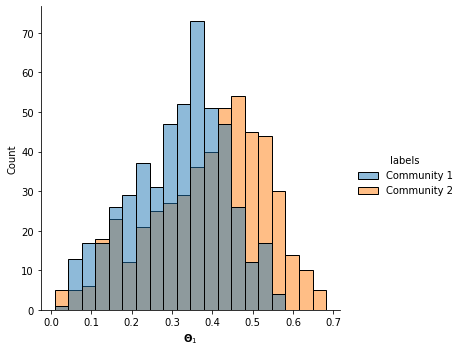

In [251]:
import n_sphere
X_sphere = n_sphere.convert_spherical(graph_latent)

x1sphere_hist = {r"$\mathbf{\Theta}_1$": X_sphere[:, 0], 'labels': labels}
x1sphere_hist = pd.DataFrame(data=x1sphere_hist)

sns.displot(data=x1sphere_hist, x=r"$\mathbf{\Theta}_1$", hue="labels", bins = 20)

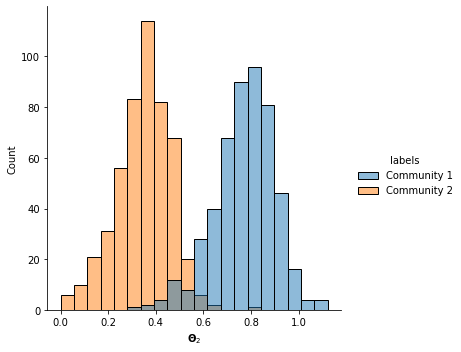

In [252]:
x2sphere_hist = {r"$\mathbf{\Theta}_2$": X_sphere[:, 1], 'labels': labels}
x2sphere_hist = pd.DataFrame(data=x2sphere_hist)

sns.displot(data=x2sphere_hist, x=r"$\mathbf{\Theta}_2$", hue="labels", bins = 20)